In [79]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt


def camera_chess():
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
    return objpoints, imgpoints

objp, imgp = camera_chess()
cv2.destroyAllWindows()

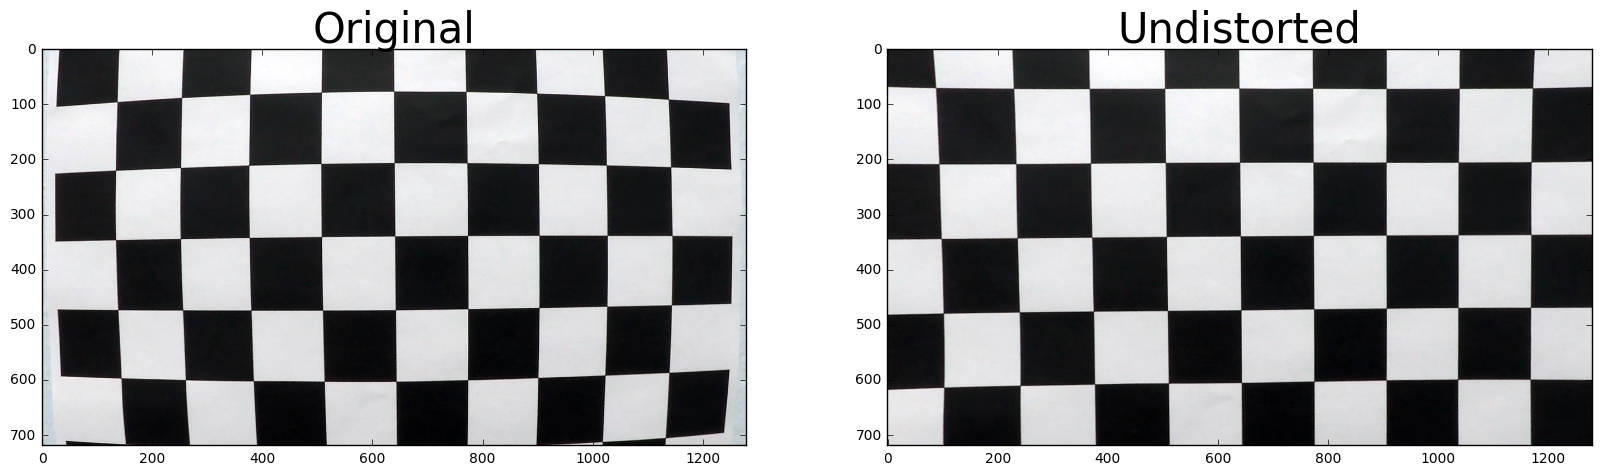

In [80]:
input_distorted = "camera_cal/calibration1.jpg"
output_undistorted = "output_images/undistorted_calibration1.jpg"

def undistort(img):    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, (img.shape[0], img.shape[1]), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = cv2.imread(input_distorted)
undist = undistort(img)
cv2.imwrite(output_undistorted, undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=30)

(720, 1280)
(720, 1280)


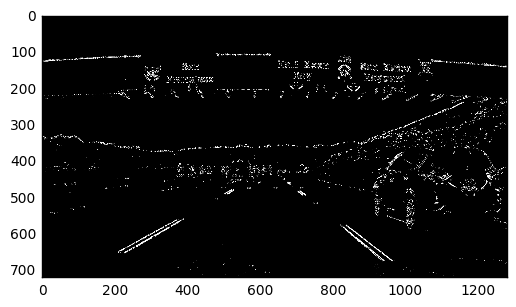

In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(gray)
    sobel = gray
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1)
    abs_sobel = np.absolute(sobel)
    avg_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output[(avg_sobel >= thresh[0]) & (avg_sobel <= thresh[1])] = 1
    print(binary_output.shape)
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1,0)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0,1)
    grad = np.sqrt(np.power(grad_x,2) + np.power(grad_y,2))
    # 3) Calculate the magnitude 
    grad = np.absolute(grad)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.uint8(255 * grad/np.max(grad))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gray)
    # 6) Return this mask as your binary_output image
    binary_output[(scale > mag_thresh[0]) & (scale < mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    grad_X = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    grad_Y = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    arctan = np.arctan2(np.absolute(grad_Y), np.absolute(grad_X))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gray)
    binary_output[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return binary_output

def filter_image_with_lane_line(image):
    
# Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 80))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 80))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 130))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.8, 1.1))


    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

img = filter_image_with_lane_line(mpimg.imread('lane.png'))
plt.figure()
plt.imshow(img, cmap='gray')